In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image

from DCGAN import Discriminator, Generator, initialize_weights

In [2]:
workers = 2
batch_size = 128
image_size = 64
image_channels = 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator

num_epochs = 15
learning_rate = 0.0002
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers

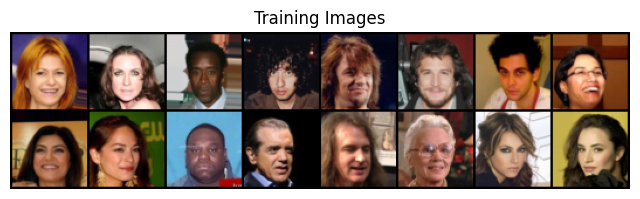

In [3]:
dataset = datasets.ImageFolder(
    root='celeb',
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [69]:
# Tensorboard
fake_writer = SummaryWriter(f'logs/fake')
real_writer = SummaryWriter(f'logs/real')
step = 0

# Loss
criterion = nn.BCELoss()

# Noise
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
print(f'Noise tensor: {fixed_noise.shape}')

real_label = 1.
fake_label = 0.

Noise tensor: torch.Size([64, 100, 1, 1])


# Training model

In [23]:
netD = Discriminator(image_channels, ndf).to(device)
netG = Generator(nz, image_channels, ngf).to(device)
netD.apply(initialize_weights)
netG.apply(initialize_weights)

optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

## Using pretrained weights

In [ ]:
netG = Generator(nz, image_channels, ngf).to(device)
netG.load_state_dict(torch.load('./weights/generator.pt')['state_dict'])
optimizerG.load_state_dict(torch.load('./weights/generator.pt')['optimizer'])
netG.eval()

netD = Discriminator(image_channels, ndf).to(device)
netD.load_state_dict(torch.load('./weights/discriminator.pt')['state_dict'])
optimizerD.load_state_dict(torch.load('./weights/discriminator.pt')['optimizer'])
netD.eval()

## Training

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(
                f'Epoch: {epoch}/{num_epochs} Batch {i}/{len(dataloader)}\n'
                f'Generator loss: {errG:.4f} '
                f'Discriminator loss: {errD:.4f}'
            )

            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img_grid_real = torchvision.utils.make_grid(real_cpu[:16], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:16], normalize=True)
                real_writer.add_image("real", img_grid_real, global_step=step)
                fake_writer.add_image("fake", img_grid_fake, global_step=step)

        step += 1

## Saving model wights

In [ ]:
stateG = {
    'epoch': 15,
    'state_dict': netG.state_dict(),
    'optimizer': optimizerG.state_dict()
}

stateD = {
    'epoch': 15,
    'state_dict': netD.state_dict(),
    'optimizer': optimizerD.state_dict(),
}

torch.save(stateG, './weights/generator.pt')
torch.save(stateD, './weights/discriminator.pt')

## Saving model

In [36]:
torch.save(netG, 'model.pt')

# Using model

In [37]:
model = torch.load('./model.pt')

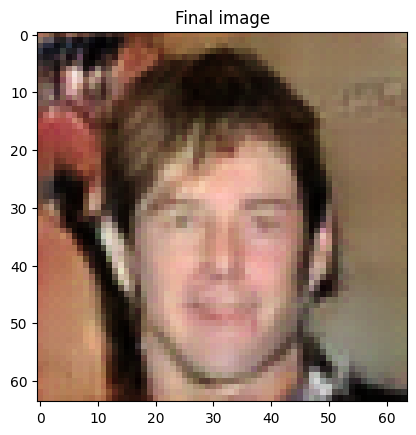

In [99]:
noise = torch.randn(1, nz, 1, 1, device=device)
image = model(noise)
plt.title("Final image")
plt.imshow(np.transpose(vutils.make_grid(image.to(device), normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [100]:
save_image(image[0], 'img2.png')